In [5]:
import numpy as np
import skfuzzy as fuzz
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [ ]:
final_data_df = pd.read_csv('../preprocessedWithoutNans.csv')

In [7]:

final_data_df["weighted_text"]= 10*(final_data_df['cleaned_headline']+" ")+ 4*(final_data_df['cleaned_short_description']+" ")+final_data_df["cleaned_article_text"]
final_data_df.shape

(24925, 14)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(final_data_df.drop("category", axis = 1), final_data_df['category'], test_size=0.2, random_state=42)

In [9]:
### TF-IDF Feature Extraction

# Initialize the TF-IDF vectorizer
vectorizer_tf = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned text
tfidf_matrix = vectorizer_tf.fit_transform(X_train['weighted_text'])

# Convert the TF-IDF matrix to a DataFrame for better visualization (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer_tf.get_feature_names_out())

# Display the first few rows of the TF-IDF DataFrame
tfidf_df.head()

,aaron,abandoned,abc,ability,able,abortion,abroad,absence,absolute,absolutely,...,york,you,young,younger,youngest,youth,youtube,zero,zika,zone
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.036956,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.014916,0.020099,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.039854,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.018396,...,0.000000,0.043875,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.026866,0.043523,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.028771,0.0,0.03211,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
### LDA

# Sample preprocessed text data
documents = list(X_train['weighted_text'])

# Step 1: Create a document-term matrix (Bag of Words)
vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(documents)

# Step 2: Apply LDA
lda_model = LatentDirichletAllocation(n_components=15, random_state=42)
lda_model.fit(doc_term_matrix)

lda_features = lda_model.transform(doc_term_matrix)

lda_features_df = pd.DataFrame(lda_features, columns=[f'LDA-{i}' for i in range(lda_model.n_components)])


In [11]:
lda_features_df.head()

,LDA-0,LDA-1,LDA-2,LDA-3,LDA-4,LDA-5,LDA-6,LDA-7,LDA-8,LDA-9,LDA-10,LDA-11,LDA-12,LDA-13,LDA-14
0,0.000392,0.000392,0.000392,0.000392,0.000392,0.021169,0.000392,0.064966,0.909158,0.000392,0.000392,0.000392,0.000392,0.000392,0.000392
1,0.068998,0.000110,0.000110,0.000110,0.000110,0.000110,0.816402,0.020288,0.004742,0.088472,0.000110,0.000110,0.000110,0.000110,0.000110
2,0.340543,0.000306,0.117845,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.278811,0.019579,0.240164,0.000306
3,0.000065,0.000065,0.005089,0.038211,0.000065,0.054585,0.099810,0.516153,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.285568
4,0.000123,0.000123,0.000123,0.000123,0.000123,0.008242,0.683013,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.307272,0.000123


In [12]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=42)
tfidf_svd = svd.fit_transform(tfidf_df)


In [13]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

def build_autoencoder():
    # Input Layer (5000 features)
    input_layer = Input(shape=(5000,), name='Input')

    # Encoder
    x = Dense(2000, activation='relu')(input_layer)
    encoded = Dense(500, activation='relu', name='Encoded')(x)  # Bottleneck layer (500 features)

    # Decoder
    x = Dense(2000, activation='relu')(encoded)
    decoded = Dense(5000, activation='sigmoid', name='Decoded')(x)  # Reconstruct original dimension

    # Autoencoder Model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])

    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2000)           │    10,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoded (Dense)                 │ (None, 500)            │     1,000,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2000)           │     1,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoded (Dense)                 │ (None, 5000)           │    10,005,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,009,500 (83.96 MB)

 Trainable params: 22,009,500 (83.96 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = autoencoder.fit(
    tfidf_df, tfidf_df,  # Input = Output for reconstruction
    epochs=10,
    batch_size=2048,
    verbose=1
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 985ms/step - loss: 0.2433 - mse: 0.2433
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0312 - mse: 0.0312
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 886ms/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 741ms/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 745ms/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 811ms/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 846ms/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 797ms/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 788ms/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 829ms/step - loss: 2.0000e-04 - mse: 2.0000e-04


In [ ]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("Encoded").output)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2000)           │    10,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoded (Dense)                 │ (None, 500)            │     1,000,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,002,500 (41.97 MB)

 Trainable params: 11,002,500 (41.97 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
tfidf_ae = encoder.predict(tfidf_matrix)

624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


In [17]:
from sklearn.preprocessing import MinMaxScaler

svd_scaler = MinMaxScaler()
tfidf_svd_scale = svd_scaler.fit_transform(tfidf_svd)


ae_scaler = MinMaxScaler()
tfidf_ae_scale = ae_scaler.fit_transform(tfidf_ae)

In [18]:
tfidf_ae_scale

array([[0.        , 0.176261  , 0.19833595, ..., 0.        , 0.19398282,
        0.1906146 ],
       [0.        , 0.39513838, 0.3857348 , ..., 0.        , 0.4101029 ,
        0.39286798],
       [0.        , 0.24869747, 0.2659567 , ..., 0.        , 0.25165582,
        0.24411948],
       ...,
       [0.        , 0.2752375 , 0.2835923 , ..., 0.        , 0.27976245,
        0.282471  ],
       [0.        , 0.15089335, 0.16859919, ..., 0.        , 0.1607808 ,
        0.15561168],
       [0.        , 0.3734141 , 0.3880673 , ..., 0.        , 0.37686926,
        0.36459708]], dtype=float32)

In [19]:
tfidf_svd_scale

array([[0.22823969, 0.1308133 , 0.87380843, ..., 0.35076641, 0.53527163,
        0.511296  ],
       [0.34314701, 0.23307284, 0.27822842, ..., 0.41120957, 0.55911332,
        0.60297146],
       [0.27261286, 0.23343441, 0.35567748, ..., 0.17536939, 0.22450494,
        0.28711173],
       ...,
       [0.27531603, 0.21357363, 0.18306339, ..., 0.70124287, 0.48879799,
        0.47851924],
       [0.16329128, 0.31945841, 0.32344468, ..., 0.35522422, 0.42454951,
        0.36342262],
       [0.42224198, 0.2864317 , 0.28859574, ..., 0.28885482, 0.31431478,
        0.61087232]])

In [20]:
added_=tfidf_svd_scale+tfidf_ae_scale
tfidf_added_=pd.DataFrame(added_ , columns=["Tfid-"+str(i) for i in range(500)])

In [21]:
tfidf_added_

,Tfid-0,Tfid-1,Tfid-2,Tfid-3,Tfid-4,Tfid-5,Tfid-6,Tfid-7,Tfid-8,Tfid-9,...,Tfid-490,Tfid-491,Tfid-492,Tfid-493,Tfid-494,Tfid-495,Tfid-496,Tfid-497,Tfid-498,Tfid-499
0,0.228240,0.307074,1.072144,0.327105,0.499627,0.236263,0.813322,0.440254,0.342197,0.676669,...,0.694936,0.783856,0.610591,0.746495,0.715683,0.573063,0.539212,0.350766,0.729254,0.701911
1,0.343147,0.628211,0.663963,0.388617,0.937814,0.357695,0.726891,0.634393,0.585027,0.864344,...,1.039347,0.405487,0.785542,0.872173,0.909416,0.942852,0.904345,0.411210,0.969216,0.995839
2,0.272613,0.482132,0.621634,0.424703,0.685490,0.404477,0.684540,0.459916,0.492682,0.938369,...,0.687360,0.395574,0.818190,0.989019,1.071845,0.505341,0.899441,0.175369,0.476161,0.531231
3,0.386456,0.728396,0.796820,0.266169,0.950916,0.468963,0.881041,0.655214,0.657157,0.834237,...,0.968210,0.554798,1.073319,0.875106,1.100459,0.920348,1.006031,0.447690,0.774997,0.851710
4,0.603024,0.631076,0.685650,0.709693,0.879297,0.398006,1.085664,0.876559,0.747433,0.818312,...,0.971491,0.428056,0.888517,1.204494,1.050451,0.936827,1.076485,0.386861,0.733601,1.120305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19935,0.102107,0.361525,0.637923,0.347490,0.596800,0.361094,0.630436,0.395602,0.325083,0.606784,...,0.712734,0.608297,0.582967,0.591340,0.824403,0.618333,0.621941,0.670009,0.580549,0.664320
19936,0.438094,0.779038,0.767928,0.400444,0.931974,0.412371,0.742592,0.689937,0.686156,0.945309,...,0.975189,0.450129,0.747049,1.251918,0.784387,0.933420,0.921837,0.451693,0.966868,1.145624
19937,0.275316,0.488811,0.466656,0.507666,0.662530,0.294829,0.871723,0.646448,0.510169,0.678079,...,0.896125,0.480304,0.660323,0.751177,0.936875,0.622101,0.783394,0.701243,0.768560,0.760990
19938,0.163291,0.470352,0.492044,0.244260,0.696419,0.624275,0.786753,0.413862,0.347808,0.695841,...,0.750595,0.424766,0.698932,0.673047,0.700045,0.560012,0.627602,0.355224,0.585330,0.519034


In [22]:
tfidf_added_['id'] = X_train['Index_Column'].values
lda_features_df['id'] = X_train['Index_Column'].values

# Merging the LDA features with the TF-IDF features
final_features_df = pd.merge(tfidf_added_, lda_features_df, on='id', how='left')

# Displaying the combined features DataFrame
final_features_df.head()

# final_features_df.to_csv("final_features_df.csv", index = False)

,Tfid-0,Tfid-1,Tfid-2,Tfid-3,Tfid-4,Tfid-5,Tfid-6,Tfid-7,Tfid-8,Tfid-9,...,LDA-5,LDA-6,LDA-7,LDA-8,LDA-9,LDA-10,LDA-11,LDA-12,LDA-13,LDA-14
0,0.228240,0.307074,1.072144,0.327105,0.499627,0.236263,0.813322,0.440254,0.342197,0.676669,...,0.021169,0.000392,0.064966,0.909158,0.000392,0.000392,0.000392,0.000392,0.000392,0.000392
1,0.343147,0.628211,0.663963,0.388617,0.937814,0.357695,0.726891,0.634393,0.585027,0.864344,...,0.000110,0.816402,0.020288,0.004742,0.088472,0.000110,0.000110,0.000110,0.000110,0.000110
2,0.272613,0.482132,0.621634,0.424703,0.685490,0.404477,0.684540,0.459916,0.492682,0.938369,...,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.278811,0.019579,0.240164,0.000306
3,0.386456,0.728396,0.796820,0.266169,0.950916,0.468963,0.881041,0.655214,0.657157,0.834237,...,0.054585,0.099810,0.516153,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.285568
4,0.603024,0.631076,0.685650,0.709693,0.879297,0.398006,1.085664,0.876559,0.747433,0.818312,...,0.008242,0.683013,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.307272,0.000123


In [69]:
final_features_df

,Tfid-0,Tfid-1,Tfid-2,Tfid-3,Tfid-4,Tfid-5,Tfid-6,Tfid-7,Tfid-8,Tfid-9,...,LDA-5,LDA-6,LDA-7,LDA-8,LDA-9,LDA-10,LDA-11,LDA-12,LDA-13,LDA-14
0,0.228240,0.307074,1.072144,0.327105,0.499627,0.236263,0.813322,0.440254,0.342197,0.676669,...,0.021169,0.000392,0.064966,0.909158,0.000392,0.000392,0.000392,0.000392,0.000392,0.000392
1,0.343147,0.628211,0.663963,0.388617,0.937814,0.357695,0.726891,0.634393,0.585027,0.864344,...,0.000110,0.816402,0.020288,0.004742,0.088472,0.000110,0.000110,0.000110,0.000110,0.000110
2,0.272613,0.482132,0.621634,0.424703,0.685490,0.404477,0.684540,0.459916,0.492682,0.938369,...,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.278811,0.019579,0.240164,0.000306
3,0.386456,0.728396,0.796820,0.266169,0.950916,0.468963,0.881041,0.655214,0.657157,0.834237,...,0.054585,0.099810,0.516153,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.285568
4,0.603024,0.631076,0.685650,0.709693,0.879297,0.398006,1.085664,0.876559,0.747433,0.818312,...,0.008242,0.683013,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.307272,0.000123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19935,0.102107,0.361525,0.637923,0.347490,0.596800,0.361094,0.630436,0.395602,0.325083,0.606784,...,0.117625,0.000358,0.321804,0.000358,0.000358,0.000358,0.462081,0.000358,0.000358,0.000358
19936,0.438094,0.779038,0.767928,0.400444,0.931974,0.412371,0.742592,0.689937,0.686156,0.945309,...,0.000074,0.305602,0.078956,0.104194,0.000074,0.000074,0.000074,0.000074,0.000074,0.258996
19937,0.275316,0.488811,0.466656,0.507666,0.662530,0.294829,0.871723,0.646448,0.510169,0.678079,...,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.997415,0.000185
19938,0.163291,0.470352,0.492044,0.244260,0.696419,0.624275,0.786753,0.413862,0.347808,0.695841,...,0.470482,0.000381,0.000381,0.000381,0.000381,0.000381,0.000381,0.000381,0.000381,0.000381


10066231505.115631
8953195603.540346
8923146114.897482
8910222353.907124
8907922189.05963
Converged
Cluster centers:
 [[0.31103587 0.58881714 0.64425728 ... 0.05102728 0.08091259 0.07517335]
 [0.3075969  0.58724291 0.6408     ... 0.05938836 0.08140112 0.07993737]
 [0.30743397 0.58868453 0.63967192 ... 0.05645377 0.08350987 0.08126   ]
 ...
 [0.31852374 0.60169171 0.64784368 ... 0.05444634 0.08649508 0.08275922]
 [0.30969358 0.59787798 0.64746187 ... 0.05074593 0.07125923 0.09479381]
 [0.31319856 0.59688006 0.64465792 ... 0.04972429 0.07996097 0.08282551]]
Labels assigned to points:
 [13 10  3 ...  5  4  8]


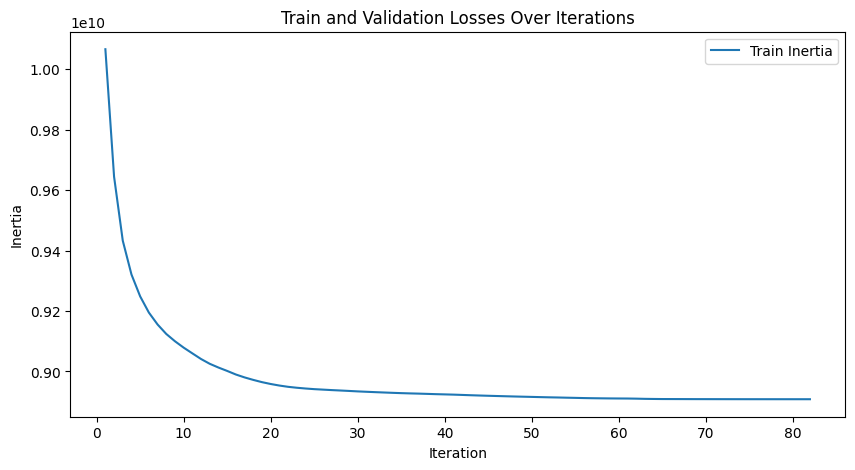

In [24]:
# final_features_df = pd.read_csv('final_features_df.csv')

n_clusters_KMeans = 15

# K-Means clustering
kmeans_model = KMeans(
    n_clusters = n_clusters_KMeans,       # Number of clusters to form
    init = 'k-means++',   # Initialization method for centroids ('random' or 'k-means++')
    n_init = 1,          # Number of times the algorithm will run with different centroid seeds
    max_iter = 1,    # Maximum number of iterations for a single run
    random_state = 42     # Random seed for reproducibility
)

training_losses_KMeans = []
n_iterations_KMeans = 5000

prev = kmeans_model

for iteration in range(n_iterations_KMeans):
    if iteration == 0:
        # For the first iteration, fit normally
        kmeans_model.fit(final_features_df)
    else:
        # Use previous cluster centers as initialization for subsequent iterations
        kmeans_model = KMeans(
            n_clusters=prev.n_clusters,
            init=prev.cluster_centers_,
            n_init=1,  # Only one initialization since we provide the centers
            max_iter = 1,
            random_state=42,
        )
        kmeans_model.fit(final_features_df)
        if (prev.inertia_== kmeans_model.inertia_):
            print("Converged")
            break

    training_losses_KMeans.append(kmeans_model.inertia_)
   
    prev = kmeans_model
    if (iteration%20==0):
        print(kmeans_model.inertia_)



cluster_membership_KMeans = kmeans_model.fit(final_features_df)

# Outputs
print("Cluster centers:\n", kmeans_model.cluster_centers_)
print("Labels assigned to points:\n", kmeans_model.labels_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(training_losses_KMeans) + 1), training_losses_KMeans, label='Train Inertia')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.title('Train and Validation Losses Over Iterations')
plt.legend()
plt.show()

In [3]:
final_data_df.head()

NameError: name 'final_data_df' is not defined

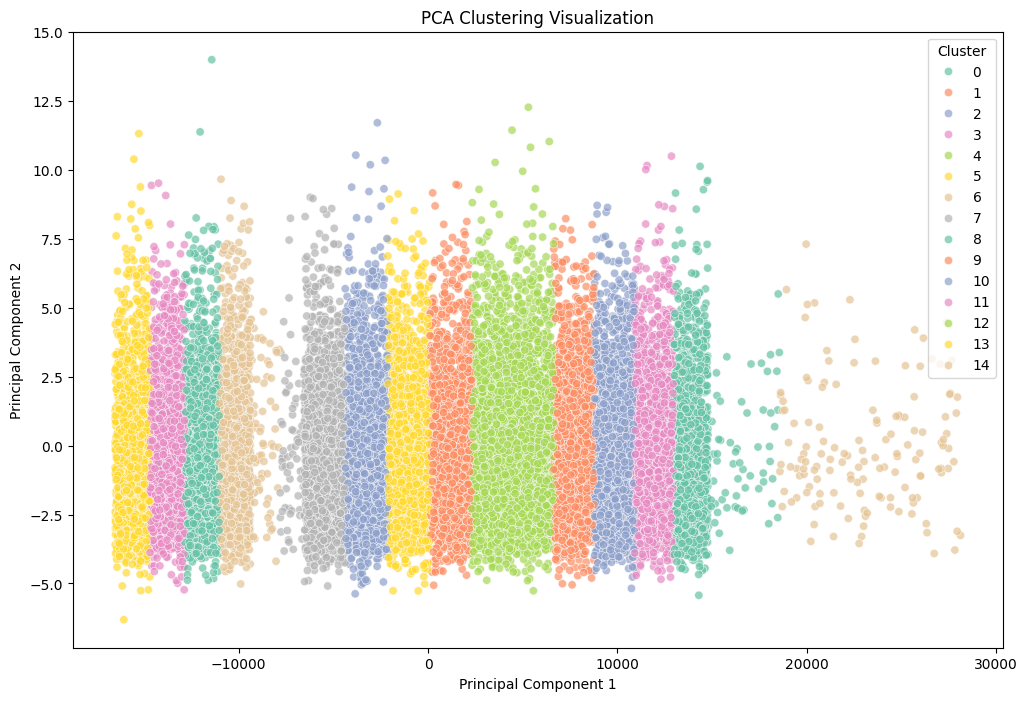

In [26]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce to 2D using PCA
pca = PCA(n_components=2, random_state=42)
pca_reduced_data = pca.fit_transform(final_features_df)  # Replace with your 500-dimensional data
cluster_labels=kmeans_model.labels_
# Convert to DataFrame for better handling
pca_df = pd.DataFrame(pca_reduced_data, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = kmeans_model.labels_  # Add cluster labels from clustering algorithm

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Cluster',
    palette=sns.color_palette('Set2', len(set(cluster_labels))),
    data=pca_df,
    legend='full',
    alpha=0.7
)
plt.title('PCA Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


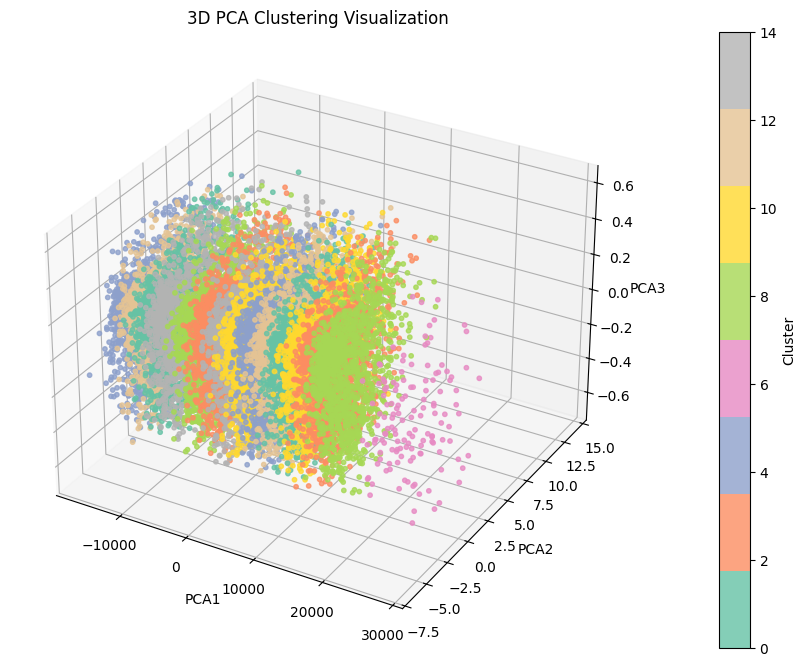

In [27]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D using PCA
pca_3d = PCA(n_components=3, random_state=42)
pca_reduced_data_3d = pca_3d.fit_transform(final_features_df)

# Convert to DataFrame
pca_df_3d = pd.DataFrame(pca_reduced_data_3d, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df_3d['Cluster'] = cluster_labels

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_df_3d['PCA1'], pca_df_3d['PCA2'], pca_df_3d['PCA3'],
    c=pca_df_3d['Cluster'], cmap='Set2', s=10, alpha=0.8
)

plt.colorbar(scatter, ax=ax, pad=0.1, label='Cluster')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('3D PCA Clustering Visualization')
plt.show()


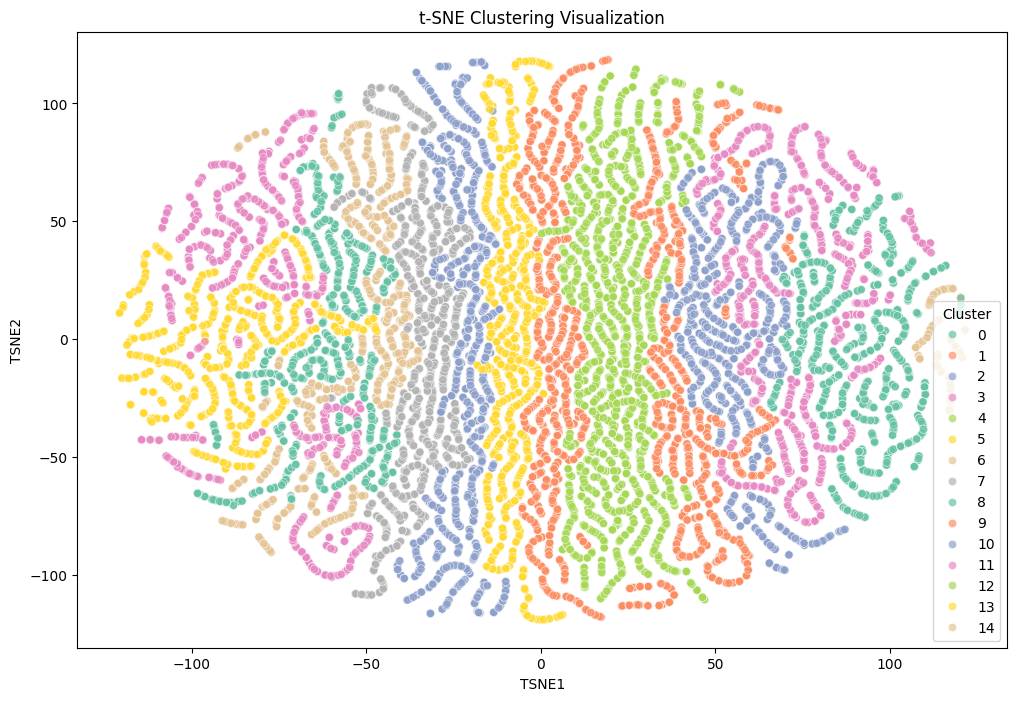

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=3)
reduced_data = tsne.fit_transform(final_features_df)  # Replace with your 500-dimensional data

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

cluster_labels=kmeans_model.labels_
reduced_data=reduced_data
import pandas as pd
tsne_df = pd.DataFrame(reduced_data, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = cluster_labels  # Add cluster labels

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='Cluster',
    palette=sns.color_palette('Set2', len(set(cluster_labels))),
    data=tsne_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE Clustering Visualization')
plt.show()




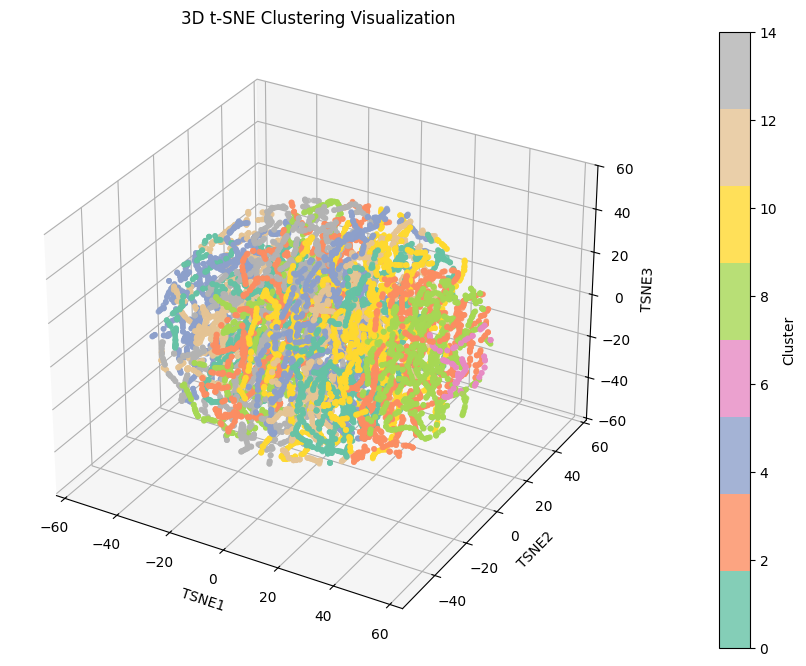

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE to reduce dimensions to 3D
tsne = TSNE(n_components=3, random_state=42, perplexity=3)
reduced_data_3d = tsne.fit_transform(final_features_df)  # Replace with your 500-dimensional data

# Prepare a DataFrame for easy handling
tsne_df_3d = pd.DataFrame(reduced_data_3d, columns=['TSNE1', 'TSNE2', 'TSNE3'])
tsne_df_3d['Cluster'] = cluster_labels  # Add cluster labels

# Plot in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    tsne_df_3d['TSNE1'], 
    tsne_df_3d['TSNE2'], 
    tsne_df_3d['TSNE3'], 
    c=tsne_df_3d['Cluster'], 
    cmap='Set2', 
    s=10, 
    alpha=0.8
)

# Add a color bar
plt.colorbar(scatter, ax=ax, pad=0.1, label='Cluster')

# Axis labels
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
plt.title('3D t-SNE Clustering Visualization')
plt.show()


In [ ]:
import random
from sklearn.metrics.pairwise import cosine_similarity
def predict_articles(article, model, num_articles = 3):

    temp_tfidf_matrix = vectorizer_tf.transform([article["weighted_text"]])

    # Convert the TF-IDF matrix to a DataFrame for better visualization (optional)
    temp_tfidf_df = pd.DataFrame(temp_tfidf_matrix.toarray(), columns=vectorizer_tf.get_feature_names_out())

    temp_document = article["weighted_text"]

    temp_doc_term_matrix = vectorizer.transform([temp_document])

    temp_lda_features = lda_model.transform(temp_doc_term_matrix)

    temp_lda_features_df = pd.DataFrame(temp_lda_features, columns=[f'LDA-{i}' for i in range(lda_model.n_components)])

    temp_tfidf_ae = encoder.predict(temp_tfidf_matrix)

    temp_tfidf_svd = svd.transform(temp_tfidf_df)

    temp_tfidf_svd_scale = svd_scaler.transform(temp_tfidf_svd)

    temp_tfidf_ae_scale = ae_scaler.transform(temp_tfidf_ae)

    temp_added_ = temp_tfidf_svd_scale + temp_tfidf_ae_scale
    temp_tfidf_added_ = pd.DataFrame(temp_added_ , columns=["Tfid-"+str(i) for i in range(500)])

    temp_tfidf_added_['id'] = article["Index_Column"]
    temp_lda_features_df['id'] = article["Index_Column"]

    # Merging the LDA features with the TF-IDF features
    temp_final_features_df = pd.merge(temp_tfidf_added_, temp_lda_features_df, on='id', how='left')

    cll=kmeans_model.predict(temp_final_features_df)
    
    same_cluster_indices = [i for i, label in enumerate(kmeans_model.labels_) if label == cll]
    same_cluster_features = final_features_df.iloc[same_cluster_indices, :]
    similarities = cosine_similarity(temp_final_features_df, same_cluster_features)
    ranked_indices = similarities.argsort()[0][::-1]
    recommended_articles = [X_train.iloc[i,:] for i in ranked_indices[:num_articles]]
    recommended_articles_labels=[Y_train.iloc[i] for i in ranked_indices[:num_articles]]
    return recommended_articles,recommended_articles_labels
        


KMeans(init=array([[0.31103587, 0.58881714, 0.64425728, ..., 0.05102728, 0.08091259,
        0.07517335],
       [0.3075969 , 0.58724291, 0.6408    , ..., 0.05938836, 0.08140112,
        0.07993737],
       [0.30743397, 0.58868453, 0.63967192, ..., 0.05645377, 0.08350987,
        0.08126   ],
       ...,
       [0.31852374, 0.60169171, 0.64784368, ..., 0.05444634, 0.08649508,
        0.08275922],
       [0.30969358, 0.59787798, 0.64746187, ..., 0.05074593, 0.07125923,
        0.09479381],
       [0.31319856, 0.59688006, 0.64465792, ..., 0.04972429, 0.07996097,
        0.08282551]]),
       max_iter=1, n_clusters=15, n_init=1, random_state=42)

In [144]:
idx = random.sample(range(X_test.shape[0]), 1)[0]
print(Y_test.iloc[idx])
x,y=predict_articles(X_test.iloc[idx,:],"",1)

print(x)
print(y)


SPORTS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[Unnamed: 0.1                                                             23297
link                         https://www.huffingtonpost.com/entry/selection...
headline                     Selection Sunday Live Blog: 2014 NCAA Tourname...
short_description            SCROLL DOWN FOR UPDATES AS THE 68 TEAMS ARE AN...
authors                                                                    NaN
date                                                                2014-03-16
Index_Column                                                             23297
article_text                 It's time for spots in the2014 NCAA Tournament...
cleaned_article_text         time spot the ncaa tournament allotted bubble ...
cleaned_headline             selection sunday live blog  ncaa tournament te...
cleaned_short_description    scroll update  team announced ncaa tournament ...
Unnamed: 0                                                                 NaN
weight

[Unnamed: 0.1                                                             16640
link                         https://www.huffingtonpost.com/entry/how-to-ma...
headline                               How to Manage Talent in a Networked Age
short_description            Organizations are struggling to find a new way...
authors                      Jacob Morgan, ContributorAuthor, The Future of...
date                                                                2014-11-14
Index_Column                                                             16640
article_text                 Author, The Future of Work, Speaker, Futurist ...
cleaned_article_text         author future work speaker futurist episode ca...
cleaned_headline                                   manage talent networked age
cleaned_short_description    organization struggling find new way working e...
Unnamed: 0                                                              6640.0
weighted_text                manage talent networke

['BUSINESS']


In [96]:
similarities

array([[0.99999998, 1.        , 0.99999999, ..., 0.99999999, 0.99999999,
        0.99999997]])

In [97]:
ranked_indices = similarities.argsort()[0][::-1]
ranked_indices

array([ 170,  439,  599, ..., 1102,  719,  682], dtype=int64)

In [102]:
X_train.iloc[170,:]
Y_train.iloc[682]

'STYLE & BEAUTY'

In [89]:
Y_test.iloc[idx]

'ENTERTAINMENT'

In [ ]:


indices = random.sample(range(X_test.shape[0]), 10)

predicted_articles = []

for i in indices:
    print("For the Article:")
    print(X_test.iloc[i, :])
    print("----------------------------------------------------------------------------------")
    print("The following are the predicted articles:")
    predicted_articles.append(predict_articles(X_test.iloc[i, :], "KMeans"))
    for j in range(len(predicted_articles[-1])):
        print(predicted_articles[-1][j])
        print("----------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------")

In [67]:
# import numpy as np
# import matplotlib.pyplot as plt
# import skfuzzy as fuzz

# # Number of clusters
# n_clusters_FC = 15

# # Apply Fuzzy C-Means Clustering
# centres, initial_membership_matrix, final_membership_matrix, distances_matrix, obj_func_values, iteration_count, fpc = fuzz.cluster.cmeans(
#     final_features_df.T,  # Transpose the data frame so features are columns
#     n_clusters_FC,
#     m=2.0,  # Fuzziness parameter
#     error=1e-5,
#     maxiter=100,
#     init=None  # You can specify initial cluster centers if desired
# )

# # Get the hard cluster membership for each data point
# cluster_membership_FC = np.argmax(final_membership_matrix, axis=0)

# # Calculate the fuzzy loss
# loss_fcm = np.sum((final_membership_matrix ** 2) * (distances_matrix ** 2))
# print("Fuzzy C-Means Loss (J):", loss_fcm)

# # Visualize the clustering results (assuming 2D data)
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(final_features_df.iloc[:, 0], final_features_df.iloc[:, 1], c=cluster_membership_FC, cmap='viridis', marker='o', edgecolor='k')

# # Plot centroids
# centroids = centres.T
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, linewidths=3)

# plt.title('Fuzzy C-Means Clustering')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.colorbar(scatter, label='Cluster Label')
# plt.show()
